# Heatwave: Change under climate scenarios workflow [Hazard assessment]

# Step 1: Description

**Content:**
- **1.1** Sources of the Heat-related products provided by **CDS** and **Climate adapt**
- **1.2** Heatwave hazard estimation based on the **Peseta IV** methodology

### 1.1 Heatwave Hazard methodology description

**Heatwave based on the PESETA IV methodology** [[PESETA IV project](https://joint-research-centre.ec.europa.eu/peseta-projects/jrc-peseta-iv_en)]
Specifically, a heatwave is defined as a period ≥ 3 consecutive days with a maximum temperature above a daily threshold calculated for a 30-year-long reference period (for testing we choose a shorter period). At least a 30-year time series of daily values is needed to obtain a robust estimation of the indicator. The threshold is defined as the 90th percentile of daily maxima temperature, centered on a 31-day window (we used a month).

**Pros [+]**
- estimation of the yearly and monthly(seasonal) values
- 12x12km grid for years 1971-2000, 2011-2100
- the possibility of changing the temperature threshold (eg. 90 percentile)
- the treshold is estimated for each pixel 
- This methodology is better for estimating the heat not only for the summer months but also the heat occurrence for the winter and autumn months because the treshold is counted for each month from the 30 years 1971-2000, so we can detect the seasonal changes.

**Cons [-]**
- Long time for computation - for years and months (all RCPs and years for Catalunya = 50 min)  
- Do not count with minimum air temperature - especially in the mountainous regions the heat can cool down at night
- 20 GB of input data 

# Step 2: Prepare a workspace and load a libraries

### 2.1 Import packages

## Prepare your workspace
:::{admonition} In this notebook we will use the following Python libraries:
:class: hint dropdown
* [zipfile](https://docs.python.org/3/library/zipfile.html) - Provides tools for creating, reading, writing, and extracting ZIP files.
* [os](https://docs.python.org/3/library/os.html) - Provides functions for interacting with the operating system, such as file and directory manipulation.
* [rasterio](https://rasterio.readthedocs.io/en/latest/) - A library for reading and writing geospatial raster data.
* [pathlib](https://docs.python.org/3/library/pathlib.html) - Provides classes for manipulating filesystem paths in a more readable and object-oriented way.
* [cdsapi](https://cds.climate.copernicus.eu/api-how-to) - A library to request data from the datasets listed in the CDS catalogue.
* [numpy](https://numpy.org/doc/stable/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
* [xarray](https://docs.xarray.dev/en/stable/) - Introduces labels in the form of dimensions, coordinates, and attributes on top of raw NumPy-like arrays for a more intuitive experience.
* [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - A package designed for geospatial data processing in order to produce maps and other geospatial data analyses.
* [matplotlib](https://matplotlib.org/stable/) - A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
* [glob](https://docs.python.org/3/library/glob.html) - Unix style pathname pattern expansion.
* [plotly](https://plotly.com/) - A Python Graphing Library.
* [sklearn](https://scikit-learn.org/stable/modules/linear_model.html#linear-regression) - Module for performing linear regression, part of the scikit-learn machine learning library.
* [ipyleaflet](https://ipyleaflet.readthedocs.io/en/stable/) - Enables interactive maps in Jupyter notebooks using the Leaflet.js library.
* [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) - Provides interactive HTML widgets for Jupyter notebooks.
* [leafmap](https://leafmap.org/) - Simplifies interactive mapping with Python in Jupyter notebooks, leveraging Leaflet.js.
* [localtileserver](https://localtileserver.readthedocs.io/en/latest/) - Serves local raster tiles for visualization in Leaflet maps.
* [itertools](https://docs.python.org/3/library/itertools.html) - Functions for creating iterators forefficient looping.


In [3]:
import zipfile  # working with the zip folders
import os  # handling the current working directory
import rasterio  # netcdf and raster processing
from pathlib import Path  # file system paths
import cdsapi  # API downloading
import numpy as np  # 2-3D array data handling
import xarray as xr  # 2-3D array data handling
import cartopy.crs as ccrs  # netcdf data projection
import cartopy.feature as cf  # netcdf data projection
import matplotlib as mpl  # data plot
import matplotlib.pyplot as plt  # data plot
from rasterio.crs import CRS  # raster data handling
from pylab import pcolormesh, show, colorbar, plot, title, legend, subplot, savefig  # matplotlib functions for plotting
from matplotlib import pyplot  # Pyplot module for MATLAB-style plotting
from rasterio.plot import show  # Function for displaying raster data
from glob import glob  # Unix style pathname pattern expansion
import plotly.graph_objects as go  # High-level interface for creating interactive visualizations
from sklearn.linear_model import LinearRegression  # Linear regression model from scikit-learn
from ipyleaflet import Map, DrawControl, Marker, LayersControl  # Interactive maps and controls for Jupyter notebooks
import ipywidgets as widgets  # Interactive HTML widgets for Jupyter notebooks
import leafmap.leafmap as leafmap  # Geospatial data visualization and analysis with Leaflet.js
from localtileserver import get_leaflet_tile_layer, TileClient  # Serving local tiles for Leaflet maps
from itertools import chain  # Functions for creating iterators for efficient looping

### 2.2 Create a directory structure

In [4]:
# Define the directory for the flashflood workflow preprocess
workflow_folder = 'Heat_test2'
# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_folder,'data')
results_dir = os.path.join(workflow_folder,'results')
r1971_2000_dir = os.path.join(workflow_folder,'r1971_2000')
r85_2011_2040_dir = os.path.join(workflow_folder,'r85_2011_2040')
r85_2041_2070_dir = os.path.join(workflow_folder,'r85_2041_2070')
r85_2071_2100_dir = os.path.join(workflow_folder,'r85_2071_2100')
r45_2011_2040_dir = os.path.join(workflow_folder,'r45_2011_2040')
r45_2041_2070_dir = os.path.join(workflow_folder,'r45_2041_2070')
r45_2071_2100_dir = os.path.join(workflow_folder,'r45_2071_2100')
# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(data_dir))
    os.makedirs(os.path.join(results_dir))
    os.makedirs(os.path.join(r1971_2000_dir))
    os.makedirs(os.path.join(r85_2011_2040_dir))
    os.makedirs(os.path.join(r85_2041_2070_dir))
    os.makedirs(os.path.join(r85_2071_2100_dir))
    os.makedirs(os.path.join(r45_2011_2040_dir))
    os.makedirs(os.path.join(r45_2041_2070_dir))
    os.makedirs(os.path.join(r45_2071_2100_dir))

# Step 3: Calculation of the heatwave occurence

## Heatwave occurrence based on the PESETA IV methodology

### 3.1 Data download for PESETA IV 

- download of the maximum 2m air temperature (for PESETA IV), if you want to use also XCLIM download also minimum 2m air temperature

- This code will automatically download the EuroCordex maximum air temperature data for the selected period and RCP
    - In this code, you can find information about selected locations, resolutions, models, periods, etc.
    - More information about the **data** you can find here: [[CDS data source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=form)]
    - More information about what is the **RCP** can find here: [[Info about RCP](https://en.wikipedia.org/wiki/Representative_Concentration_Pathway)]
    - For **PESETA IV download only maximum 2m temperature** 

**1971-2000 maximum 2m temperature in the last 24h**

In [ ]:
# This code downloads the data for the selected time-period and rcp
## Data for the 1971-2000
c = cdsapi.Client(url=URL, key=KEY)
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_1971_2000.zip')
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'area': bbox,
        'domain': 'europe',
        'experiment': 'historical',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'gcm_model': 'cnrm_cerfacs_cm5',
        'rcm_model': 'clmcom_clm_cclm4_8_17',
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '1971', '1976', '1981', '1986', '1991', '1996', 
        ],
        'end_year': [
            '1975', '1980', '1985', '1990', '1995', '2000', 
        ],
    },
   f"{data_dir}/era5_daily_t2m_eurminmax_1971_2000.zip")

In [ ]:
# This code unzips the downloaded files in your working directory, so they will be ready for computing 
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_1971_2000.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

**2011-2100 rcp_8_5 maximum 2m temperature in the last 24h** 
(or you can select other suggested period 2041-2070, 2071-2100 or rcp 4.5 or 8.5)

In [ ]:
# This code  downloads the data for the selected time period and rcp
c = cdsapi.Client(url=URL, key=KEY)
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_2011_2100.zip')
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'europe',
        'experiment': 'rcp_8_5',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'gcm_model': 'cnrm_cerfacs_cm5',
        'rcm_model': 'clmcom_clm_cclm4_8_17',
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '2011', '2016', '2021', '2026', '2031', '2036', '2041', '2046', '2051', '2056', '2061', '2066', '2071', '2076', '2081', '2086', '2091', '2096',
        ],
        'end_year': [
            '2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100',
        ],
    },
   f"{data_dir}/era5_daily_t2m_eurminmax_2011_2100.zip")

In [ ]:
# This code unzips the downloaded files in your working directory, data will be ready for computing 
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_2011_2100.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

**2011-2100 rcp_4_5 maximum 2m temperature in the last 24h**

In [ ]:
# This code will download the data for the selected time-period and rcp
c = cdsapi.Client(url=URL, key=KEY)
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurmax_rcp45_2011_2100.zip')
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'europe',
        'experiment': 'rcp_4_5',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'gcm_model': 'cnrm_cerfacs_cm5',
        'rcm_model': 'clmcom_clm_cclm4_8_17',
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '2011', '2016', '2021', '2026', '2031', '2036', '2041', '2046', '2051', '2056', '2061', '2066', '2071', '2076', '2081', '2086', '2091', '2096',
        ],
        'end_year': [
            '2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100',
        ],
    },
   f"{data_dir}/era5_daily_t2m_eurmax_rcp45_2011_2100.zip")

In [5]:
# This code unzips the downloaded files in your working directory, so they will be ready for computing 
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurmax_rcp45_2011_2100.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

### 3.2 Load data and convert Kelvin to Celsius

In [6]:
# This code loads a data from your working directory, and set the coordinates system (CRS)
# Historical data Maximum temperature
dmaxh = xr.open_mfdataset(f'{data_dir}/tasmax*historical*.nc', decode_coords='all')
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
dmaxh.rio.write_crs(rotated_pole, inplace=True)
# Maximum temperature rcp 4.5
dmax45 = xr.open_mfdataset(f'{data_dir}/tasmax*rcp45*.nc', decode_coords='all')
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
dmax45.rio.write_crs(rotated_pole, inplace=True)
# Maximum temperature rcp 8.5
dmax85 = xr.open_mfdataset(f'{data_dir}/tasmax*rcp85*.nc', decode_coords='all')
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
dmax85.rio.write_crs(rotated_pole, inplace=True)
print("Data loaded and crs has been set!!!")

Data loaded and crs has been set!!!


### 3.3 Selection of the bbox (boundary box)

**Tip for the selection of the area:**
Select at least the area of the region or state where you want to compute (bigger area is better for graphical comparison, for EuroCordex resolution of 12x12km)
- "Zoom" to your area with [+] (top left corner)
- "Click" on the rectangle on the left panel
- "Select your area" by left click and drag
-  And run a code below which "automatically" takes the coordinates of your area and transforms it to rotated pole CRS which is used by the EuroCordex data

In [7]:
# This code plots a map where you need to select a bounding box, as an area for the heatwave estimation
# Create a map centered at a specific location
m = Map(center=(0, 0), zoom=2)
# Create lists to store rectangle coordinates
min_lon_list = []
min_lat_list = []
max_lon_list = []
max_lat_list = []
# Create a DrawControl with rectangle drawing enabled
draw_control = DrawControl(rectangle={'shapeOptions': {'color': '#ff0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)
# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)
# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Polygon':
            # Extract coordinates of the rectangle
            coords = geo_json['geometry']['coordinates'][0]
            # Compute rectangle coordinates (min_lon, min_lat, max_lon, max_lat)
            min_lon, min_lat = min(coord[0] for coord in coords), min(coord[1] for coord in coords)
            max_lon, max_lat = max(coord[0] for coord in coords), max(coord[1] for coord in coords)
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({min_lon:.2f}, {min_lat:.2f}), ({max_lon:.2f}, {max_lat:.2f})'
            # Append coordinates to lists
            min_lon_list.append(min_lon)
            min_lat_list.append(min_lat)
            max_lon_list.append(max_lon)
            max_lat_list.append(max_lat)
# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)
# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

The coordinates will be automatically taken to next steps, you do not need to copy them !!!

In [8]:
# This code extracts the coordinates from the bounding box selected above and transform it to Rotated pole coordinates
a=min_lon_list + min_lat_list
b=max_lon_list + max_lat_list
# Define the source and destination coordinate reference systems
source_crs = ccrs.PlateCarree()  # WGS84 CRS
#dest_crs = ccrs.RotatedPole(pole_longitude=190, pole_latitude=39.25, central_rotated_longitude=0)
dest_crs = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
# Example coordinates in WGS 84
#wgs84_coords = [(18.528168, 49.076529), (18.965041, 49.349247)]
wgs84_coords = [(a), (b)]
# Perform the transformation for each pair of coordinates
rotated_pole_coords = []
for lon, lat in wgs84_coords:
    rotated_pole_coords.append(dest_crs.transform_point(lon, lat, source_crs))
print("WGS 84 Coordinates:", wgs84_coords)
print("Rotated Pole Coordinates:", rotated_pole_coords)

WGS 84 Coordinates: [[17.963159, 48.788648], [19.853531, 49.607029]]
Rotated Pole Coordinates: [(-0.024286497465127812, -1.9613459534882167), (1.2012484008158797, -1.1279240507630437)]


In [9]:
# This code will create a list from the coordinates in WGS84
# Original list of tuples
list_of_tuples = wgs84_coords
# Convert the list of tuples to a single tuple
bbox84 = tuple(chain.from_iterable(list_of_tuples))
print(bbox84)

(17.963159, 48.788648, 19.853531, 49.607029)


In [10]:
# This code will create a list from the coordinates in rotated pole
# Original list of tuples
list_of_tuples2 = rotated_pole_coords
# Convert the list of tuples to a single tuple
bbox = tuple(chain.from_iterable(list_of_tuples2))
print(bbox)

(-0.024286497465127812, -1.9613459534882167, 1.2012484008158797, -1.1279240507630437)


### 3.4 Clip area of interest
The bouding box coordinates will be automatically copied after a selection of the bbox

In [11]:
# This code crops the downloaded data from CDS to your selected bounding box (selected area)
dmaxch=dmaxh.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])  
dmaxc45=dmax45.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])  
dmaxc85=dmax85.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])  

In [12]:
# This code will convert the maximum temperature data from Kelvin to Celsius. The first part will also remove unnecessary data from the disk
# Remove data from the memory
del dmaxh
del dmax45
del dmax85
# 2. Convert from K to °C
# Max Temperature historical
dmaxch=dmaxch['tasmax']
tasmaxh=dmaxch - 273.15
tasmaxh=tasmaxh.assign_attrs(dmaxch.attrs)
tasmaxh.attrs['units']='°C'
# Max Temperature rcp 45
dmaxc45=dmaxc45['tasmax']
tasmax45=dmaxc45 - 273.15
tasmax45=tasmax45.assign_attrs(dmaxc45.attrs)
tasmax45.attrs['units']='°C'
# Max Temperature rcp 85
dmaxc85=dmaxc85['tasmax']
tasmax85=dmaxc85 - 273.15
tasmax85=tasmax85.assign_attrs(dmaxc85.attrs)
tasmax85.attrs['units']='°C'
# 3. Select a time period for maximum temperature
# Max T
tasmaxh=tasmaxh.sel(time=slice("1971-01-01", "2000-12-31"))
tasmaxp1_45=tasmax45.sel(time=slice("2011-01-01", "2040-12-31"))
tasmaxp2_45=tasmax45.sel(time=slice("2041-01-01", "2070-12-31"))
tasmaxp3_45=tasmax45.sel(time=slice("2071-01-01", "2100-12-31"))
tasmaxp1_85=tasmax85.sel(time=slice("2011-01-01", "2040-12-31"))
tasmaxp2_85=tasmax85.sel(time=slice("2041-01-01", "2070-12-31"))
tasmaxp3_85=tasmax85.sel(time=slice("2071-01-01", "2100-12-31"))
#tasmaxp=tasmax.sel(time=slice("2011-01-01", "2100-12-31"))

### 3.5 Set the temperature treshold 

- **The percentile treshold for the daily maximum air temperature e.g. 0.90 = 90 percentile**

In [13]:
# the treshold given by the percentile of the maximum daily air temperature for the month for 30 years. 
temperature_treshold = 0.90

### 3.6 Define the fuction for the calculation of the number of the heatwave events

- For the extraction of the heatwave events in the future we use the 90percentile treshold from the reference period 1971-2000
- You can change the 90 percentile (treshold) for your treshold in the row ### tas_maxh90=tas_maxh.chunk(dict(time=-1)).quantile(0.90,'time')
- This will take multiple minutes (depending on the selected area, e.g. whole Catalunya = 50min)

In [ ]:
# This code calculates the heatwave occurrence for the years and months for the periods and RCP listed in the "dirs" and "years"
# Calculation of the heatwave events based on PESETA IV 
dirs= [r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]
tasx= [tasmaxh, tasmaxp1_45, tasmaxp2_45, tasmaxp3_45, tasmaxp1_85, tasmaxp2_85, tasmaxp3_85 ]
years = [(1971,2001),(2011,2041),(2041,2071),(2071,2101),(2011,2041),(2041,2071),(2071,2101)]
# Divide the time series to months 
for d, y, t in zip(dirs, years, tasx):
    start_year, end_year = y
    tasmax_month=tasmaxh.groupby('time.month').groups
    tasmax_montp1=t.groupby('time.month').groups 
    #tasmax_montp1_45=tasmaxp1_45.groupby('time.month').groups  
    #aty=at_city.groupby('time.year').groups
    # Calculate the heatwave occurence for all months in given period  
    for i in range (1, 13):
        tasmaxh_idxs=tasmax_month[i]
        tasmaxp1_idxs=tasmax_montp1[i]
        # Extract the  months by selecting the relevant indices
        #at_max=at_city.isel(time=at_idxs)
        tas_maxh=tasmaxh.isel(time=tasmaxh_idxs)
        tas_maxp1=t.isel(time=tasmaxp1_idxs)      
        # 90 percentile 
        #junq90_maxZA=jun_maxZA.chunk(dict(time=-1)).quantile(0.90,'time')
        tas_maxh90=tas_maxh.chunk(dict(time=-1)).quantile(temperature_treshold,'time')        ### Here you can change the treshold of 0.90 percentile ###
        #tas_maxp190=tas_maxp1.chunk(dict(time=-1)).quantile(0.90,'time')
        heatp1t=xr.where(tas_maxp1>tas_maxh90, 1, 0)
        # Create + time dataset
        vat=heatp1t
        v1at=heatp1t[:-1,:,:]
        v2at=heatp1t[:-2,:,:]
        v3at=heatp1t[:-3,:,:]
        # Create missing days
        t1at=heatp1t[0:1,:,:]
        t2at=heatp1t[0:2,:,:]
        t3at=heatp1t[0:3,:,:]
        # Concatenate missing dates to + time dataset
        vi1at=xr.concat([t1at, v1at], dim='time')
        vi2at=xr.concat([t2at, v2at], dim='time')
        vi3at=xr.concat([t3at, v3at], dim='time')
        # Change the time dimesion for correct one
        tiat=heatp1t["time"]
        # add a time dimension
        vi1at["time"]=tiat
        vi2at["time"]=tiat
        vi3at["time"]=tiat
        # Sum of the heatwave
        sumvat=xr.where((vat==1)&(vi1at==1)&(vi2at==1), 1, 0) # count 3 day HW
        sumv2at=xr.where((vat==1)&(vi1at==1)&(vi2at==1)&(vi3at==1), -1, 0)  
        sumvatf=sumvat+sumv2at
        for y in range(start_year, end_year):     
            sumvyp=sumvatf.groupby('time.year').groups 
            sat1p=sumvyp[y]
            sumt1p=sumvatf.isel(time=sat1p)
            sumyear1p=sumt1p.sum(dim='time')
            sumyear1p.rio.to_raster(raster_path=f'{d}/HW_' + str(y) + '_projYM_' + str(i) + '.tif')

### 3.7 Sum the heatwave events by month and years and plot the results

**Sum of the heatwave events by months historical and projections**
- This code will compute the sum of the heatwave events for each month January - December for all selected periods in the past and the future and all RCPs

In [11]:
# This code computes the sum of the heatwave events for each month jan-dec for all selected periods in the past and the future and all RCPs
# Sum of the heatwave events for months 
# List of data directory paths
data_dirs = [r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]

for d in data_dirs:
    for i in range (1,13):    
        # Read a paths for heatwaves
        HW = glob(f'{d}/*YM_' + str(i) + '.tif')
        # Create a raster stack 
        with rasterio.open(HW[0]) as src0:
            meta = src0.meta
        meta.update(count = len(HW))
        #
        with rasterio.open(f'{d}/stackHWEUM_' + str(i) + '.tif','w', **meta) as dst:
            for id, layer in enumerate(HW, start=1):
                with rasterio.open(layer) as src1:
                    dst.write_band(id, src1.read(1))
        #
    for i in range (1, 13):    
        HWEUpm=f'{d}/stackHWEUM_' + str(i) + '.tif'
        HWEUpm= xr.open_dataset(HWEUpm)
        HWEUpm=HWEUpm.sum(dim='band', skipna=True,  keep_attrs=True)
        HWEUpm=HWEUpm['band_data']
        HWEUpm.rio.to_raster(raster_path=f'{d}/HWsumM_' + str(i) + '.tif')
    #
    HW = sorted (glob(f'{d}/HWsumM_*'), key=os.path.getmtime)
    # Create a raster stack 
    with rasterio.open(HW[0]) as src0:
        meta = src0.meta
    meta.update(count = len(HW))
    #
    with rasterio.open(f'{d}/HWsumM.tif','w', **meta) as dst:
        for id, layer in enumerate(HW, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

**Sum of the heatwave by years historical and projections**
- This code will compute the sum of the heatwave events for each period for all RCPs 

In [4]:
# This code computes the sum of the heatwave events for each period for all RCPs 
# Sum of the heatwave events for years 
data_dirs = [r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]
years = [(1971,2001),(2011,2041),(2041,2071),(2071,2101),(2011,2041),(2041,2071),(2071,2101)]

for d, year_range in zip(data_dirs, years):
    start_year, end_year = year_range
    for i in range(start_year, end_year):      
        # Read a paths for heatwaves
        HW = glob(f'{d}/HW_' + str(i) + '*')
        # Create a raster stack 
        with rasterio.open(HW[0]) as src0:
            meta = src0.meta
        #
        meta.update(count = len(HW))
        #
        with rasterio.open(f'{d}/stackHWEUY_' + str(i) + '.tif','w', **meta) as dst:
            for id, layer in enumerate(HW, start=1):
                with rasterio.open(layer) as src1:
                    dst.write_band(id, src1.read(1))
    ##################################################
    for i in range(start_year, end_year):    
        HWEUp=f'{d}/stackHWEUY_' + str(i) + '.tif'
        HWEUp= xr.open_dataset(HWEUp)
        HWEUp=HWEUp.sum(dim='band', skipna=True,  keep_attrs=True)
        HWEUp=HWEUp['band_data']
        HWEUp.rio.to_raster(raster_path=f'{d}/HWsumY_' + str(i) + '.tif')
    ##################################################
    # Read a paths for heatwaves
    HW = sorted (glob(f'{d}/HWsumY_*'), key=os.path.getmtime)
    # Create a raster stack 
    with rasterio.open(HW[0]) as src0:
        meta = src0.meta
    #
    meta.update(count = len(HW))
    #
    with rasterio.open(f'{d}/HWsumY.tif','w', **meta) as dst:
        for id, layer in enumerate(HW, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))  

### 3.8 Reproject the rasters to WGS84 (EPSG:4326)

- With this code you will reproject the data from Rotated Pole to WGS84 (EPSG:4326) CRS. We need the WGS84 because the ipyleaflet maps work with this CRS.

In [5]:
# This code reprojects the computed data from the rotated pole to WGS84 (EPSG:4326)
# Define your data directories
data_dirs = [r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]
# Define the target CRS
target_crs = 'EPSG:4326'  # WGS84
for d in data_dirs:
    # Open dataset
    HWbarhm = xr.open_dataset(f'{d}/HWsumM.tif')['band_data']
    HWbarhy = xr.open_dataset(f'{d}/HWsumY.tif')['band_data']
    # Write CRS information
    HWbarhm.rio.write_crs(rotated_pole, inplace=True)
    HWbarhy.rio.write_crs(rotated_pole, inplace=True)
    # Reproject the raster dataset
    HWbarhm_reprojected = HWbarhm.rio.reproject(target_crs)
    HWbarhy_reprojected = HWbarhy.rio.reproject(target_crs)
    # Replace NaN values
    HWbarhm_reprojected = HWbarhm_reprojected.where(HWbarhm_reprojected != 1.7976931348623157e+308, np.nan)
    HWbarhy_reprojected = HWbarhy_reprojected.where(HWbarhy_reprojected != 1.7976931348623157e+308, np.nan)
    # Optionally, you can save the reprojected raster to a new file
    HWbarhm_reprojected.rio.to_raster(raster_path=f'{d}/HWbarM_reprojected.tif')
    HWbarhy_reprojected.rio.to_raster(raster_path=f'{d}/HWbarY_reprojected.tif')
    # Calculate mean and save to raster
    HWhy_mean = HWbarhy_reprojected.mean(dim='band', skipna=True, keep_attrs=True)
    HWhy_mean.rio.to_raster(raster_path=f'{d}/HWY_mean.tif')

### 3.9 Select a pixel for plotting

- With this code, you select the point on the map, for which you want to plot the bar and line graphs (select only one point, if you accidentally select multiple points, run this code (below) again and select the point again)
- The rasters ploted in the map below, represents 

In [3]:
# This code plots the map, where you will select the point for which you want to plot a graphs 
# First, create a tile server from the local raster file
data_dirs = [r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]
client1 = TileClient(f'{r1971_2000_dir}/HWY_mean.tif')
# Create ipyleaflet tile layer from that server
t1 = get_leaflet_tile_layer(client1, band= [1], cmap='Reds', opacity=0.5, nodata = 0, name='heatwave mean occurence 1971-2000')

m = Map(center=client1.center(), zoom=client1.default_zoom)

m.add(t1)

control = LayersControl(position='topright')
m.add_control(control)
# Create lists to store point coordinates
point_lon_list = []
point_lat_list = []
# Create a DrawControl with point drawing enabled
draw_control = DrawControl(marker={'shapeOptions': {'color': '#FF0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)
# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)
# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Point':
            # Extract coordinates of the point
            lon, lat = geo_json['geometry']['coordinates']
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({lon:.2f}, {lat:.2f})'
            # Append coordinates to lists
            point_lon_list.append(lon)
            point_lat_list.append(lat)
            # Create and add a marker to the map
            marker = Marker(location=(lat, lon))
            m.add_layer(marker)
# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)
# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

- Select only one point with a flag from the left panel (point marker) from within the bbox which you choose, the coordinate will be automatically copied to the next code
- If you accidentally select multiple points, reload the map again (only deleting the point will not help)
- This plot is only illustrative, for the selection of the pixel for plotting of the graphs. 
- **The skewness of the raster was caused by the transformation of the coordinate system**

### 3.10 Extract the values from the multi-and rasters based on the selected point 
- This code will extract values needed for the plotting of the results

In [10]:
# This code extract the data for the selected point in the map above
data_dirs=[r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]
def latlon_to_pixel(raster_file, lat, lon):
    with rasterio.open(raster_file) as src:
        row, col = src.index(lon, lat)
        return row, col
def get_pixel_values(raster_file, lat, lon):
    with rasterio.open(raster_file) as src:
        row, col = latlon_to_pixel(raster_file, lat, lon)
        pixel_values = [band[row, col] for band in src.read()]
        return pixel_values
# Generate raster file paths
raster_files = []
for data_dir in data_dirs:
    raster_files.extend([
        f'{data_dir}/HWbarM_reprojected.tif',
        f'{data_dir}/HWbarY_reprojected.tif'
    ])
# Example latitude and longitude
lat = point_lat_list[0]
lon = point_lon_list[0]
# Get pixel values for each raster file
pixel_values = {}
for raster_file in raster_files:
    pixel_values[raster_file] = get_pixel_values(raster_file, lat, lon)
# Example usage:
pixel_values_hm = pixel_values[f'{r1971_2000_dir}/HWbarM_reprojected.tif']
pixel_values_hy = pixel_values[f'{r1971_2000_dir}/HWbarY_reprojected.tif']
pixel_values_p1m_45 = pixel_values[f'{r45_2011_2040_dir}/HWbarM_reprojected.tif']
pixel_values_p1y_45 = pixel_values[f'{r45_2011_2040_dir}/HWbarY_reprojected.tif']
pixel_values_p2m_45 = pixel_values[f'{r45_2041_2070_dir}/HWbarM_reprojected.tif']
pixel_values_p2y_45 = pixel_values[f'{r45_2041_2070_dir}/HWbarY_reprojected.tif']
pixel_values_p3m_45 = pixel_values[f'{r45_2071_2100_dir}/HWbarM_reprojected.tif']
pixel_values_p3y_45 = pixel_values[f'{r45_2071_2100_dir}/HWbarY_reprojected.tif']
pixel_values_p1m_85 = pixel_values[f'{r85_2011_2040_dir}/HWbarM_reprojected.tif']
pixel_values_p1y_85 = pixel_values[f'{r85_2011_2040_dir}/HWbarY_reprojected.tif']
pixel_values_p2m_85 = pixel_values[f'{r85_2041_2070_dir}/HWbarM_reprojected.tif']
pixel_values_p2y_85 = pixel_values[f'{r85_2041_2070_dir}/HWbarY_reprojected.tif']
pixel_values_p3m_85 = pixel_values[f'{r85_2071_2100_dir}/HWbarM_reprojected.tif']
pixel_values_p3y_85 = pixel_values[f'{r85_2071_2100_dir}/HWbarY_reprojected.tif']

### 3.11 Plot the comparison by months for selected pixel

- The plot of the bar chart comparison of the heatwave occurrence for the selected point

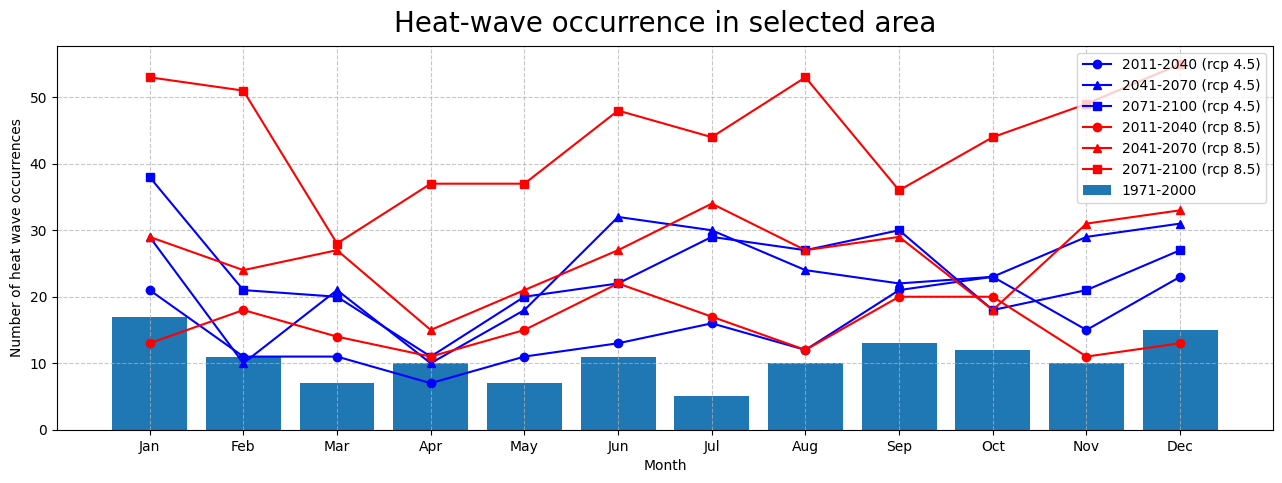

In [13]:
# This code plots the results for the selected point 
#list_values= [pixel_values_p1m, pixel_values_p2m, pixel_values_p3m]
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bar = pixel_values_hm
line1 = pixel_values_p1m_45
line2 = pixel_values_p2m_45
line3 = pixel_values_p3m_45
line4 = pixel_values_p1m_85
line5 = pixel_values_p2m_85
line6 = pixel_values_p3m_85
fig, ax = plt.subplots()
ax.bar(month, bar, label='1971-2000')
ax.plot(month, line1, color='blue', marker='o', label='2011-2040 (rcp 4.5)')
ax.plot(month, line2, color='blue', marker="^", label='2041-2070 (rcp 4.5)')
ax.plot(month, line3, color='blue', marker='s', label='2071-2100 (rcp 4.5)')
ax.plot(month, line4, color='red', marker='o', label='2011-2040 (rcp 8.5)')
ax.plot(month, line5, color='red', marker="^", label='2041-2070 (rcp 8.5)')
ax.plot(month, line6, color='red', marker='s', label='2071-2100 (rcp 8.5)')
ax.set_xlabel('Month')
ax.set_ylabel('Number of heatwave occurrences')
ax.set_title('heatwave occurrence in selected area', fontsize=20, pad=10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.1, bottom=0.1, right=2, top=0.9)
plt.show()

- This graph compares the heatwave occurrence for month of years 1971-2000 and 2011-2040, 2041-2070, 2071-2100 for RCP 4.5 and 8.5
- **The heatwave occurrence for months is based on the 90-percentile treshold for each month from reference period 1971-2000. This treshold was used for all projection periods. That's why we can also find heatwaves in the winter and autumn months. We should understand the heatwave occurrence in the winter and autumn months, as a periods when the daily maximum temperature exceeds the 90 percentile temperature treshold computed for the given month from 30 years reference (historical) period 1971-2000.**
- These results give us an idea of heatwave distribution throughout the year in the past and in the near and far future for different scenarios RCPs
- We need to also realize that the heat occurrence in the winter will have a different impact than the heat occurrence in the summer. The winter heat occurrence can influence the of the snow, animals, and plants for more see [[Heat effects on human nature](https://theconversation.com/four-ways-winter-heatwaves-affect-humans-and-nature-197365)]. The summer heatwaves will have a negative effect on the human health, water scarcity etc. [[Climate adapt effect on human health](https://climate-adapt.eea.europa.eu/en/knowledge/tools/urban-adaptation/climatic-threats/heatwaves)]

### 3.12 Plot the comparison by years for selected pixel

We compare the heatwave occurrence in the observed period (1971-2000) and projection (2011-2100) for chosen rcp. We selected these periods because these are the most used climate periods by CDS. 

- On this graph you can see the heatwave occurence for the reference period 1971-2000 and projection periods 2011-2100
- The number of heatwave occurence for each year represents the the sum of the heat have occurence for each year (also winter and autumn months)

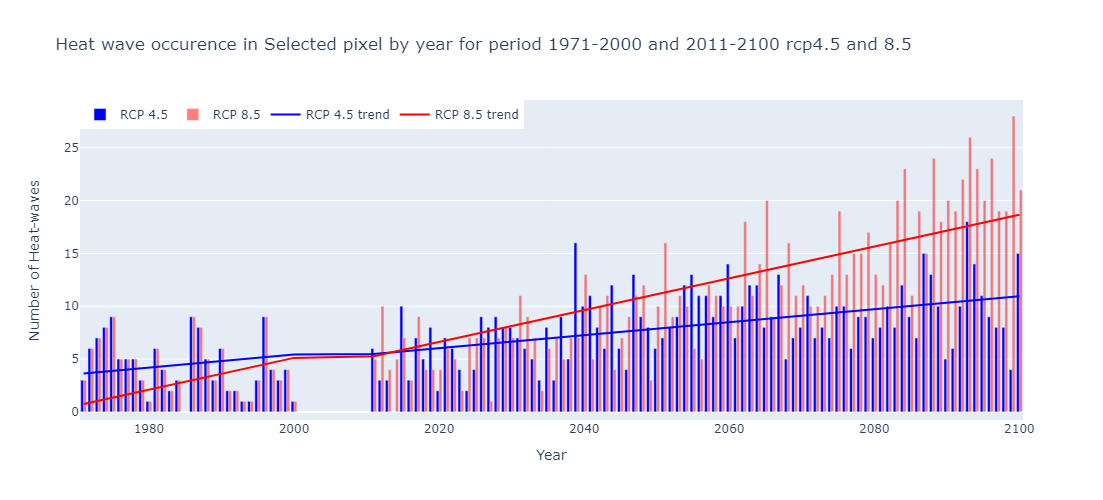

In [33]:
# This code plots the heatwave occurrence for the selected point for years 
# Sample data
b = pixel_values_hy + pixel_values_p1y_45 + pixel_values_p2y_45 + pixel_values_p3y_45
t = pixel_values_hy + pixel_values_p1y_85 + pixel_values_p2y_85 + pixel_values_p3y_85
# Calculate trend lines for b and t
b_trend = np.polyfit(np.arange(len(b)), b, 1)
t_trend = np.polyfit(np.arange(len(t)), t, 1)
# Define years
yearh = list(range(1971, 2001))
yearp1 = list(range(2011, 2101))
year = yearh + yearp1
# Create figure
fig = go.Figure()
# Add bar trace for 'b'
fig.add_trace(go.Bar(x=year, y=b, name='RCP 4.5', marker_color='blue'))
# Add bar trace for 't'
fig.add_trace(go.Bar(x=year, y=t, name='RCP 8.5', opacity=0.5, marker_color='red'))
# Add trend line trace for 'b'
fig.add_trace(go.Scatter(x=year, y=np.polyval(b_trend, np.arange(len(b))), mode='lines', name='RCP 4.5 trend', line=dict(color='blue')))
# Add trend line trace for 't'
fig.add_trace(go.Scatter(x=year, y=np.polyval(t_trend, np.arange(len(t))), mode='lines', name='RCP 8.5 trend', line=dict(color='red')))
# Update layout
fig.update_layout(
    title='heatwave occurence in Selected pixel by year for period 1971-2000 and 2011-2100 rcp4.5 and 8.5',
    xaxis_title='Year',
    yaxis_title='Number of heatwaves',
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    width=1100,
    height=500)

## 4. Conclusion for Peseta IV results

Monthly comparison shows in which months we can expect the highest increase in the heatwave occurrence. Yearly comparisons show that the trend of heatwave occurrence should rise, however, how steep the trendline will be depends on the rcp and area you choose. 

## 5. References 

- Copernicus Climate Data Store, heatwave days for European countries derived from climate projections (2021), https://cds.climate.copernicus.eu/cdsapp#!/software/app-health-heatwaves-projections?tab=app [2024-06-17]. 

- Copernicus Climate Data Store, heatwave days for Europe derived from ERA5 reanalysis (2021), https://cds.climate.copernicus.eu/cdsapp#!/software/app-health-heatwaves-current-climate?tab=app [2024-06-17].

- Copernicus Climate Data Store, heatwave days and heat-related mortality for nine European cities (2021), https://cds.climate.copernicus.eu/cdsapp#!/software/app-health-urban-heat-related-mortality-projections?tab=app [2024-06-17].

- Joint research center, JRC PESETA IV (2022), https://joint-research-centre.ec.europa.eu/peseta-projects/jrc-peseta-iv_en [2024-06-17].
 
- Copernicus Climate Data Store, CORDEX regional climate model data on single levels (2019), https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=overview [2024-06-17].

- Copernicus Climate Change Service, Climate Data Store, (2019): CORDEX regional climate model data on single levels. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.bc91edc3 (Accessed on 2024-06-17)

- Climate adapt, Apparent temperature heatwave days (2021), https://climate-adapt.eea.europa.eu/en/metadata/indicators/apparent-temperature-heatwave-days [2024-06-17].

- Climate adapt, Tropical nights (2021), https://climate-adapt.eea.europa.eu/en/observatory/++aq++metadata/indicators/tropical-nights/ [2024-06-17].

- Climate adapt, High UTCI Days (2021), https://climate-adapt.eea.europa.eu/en/metadata/indicators/high-utci-days [2024-06-17].

- Climate adapt, EuroHEATonline heatwave forecast (2007), https://climate-adapt.eea.europa.eu/en/metadata/tools/EuroHEAT-online-heatwave-forecast [2024-06-17]

## 6. Authors

- Martin Kuban, KAJO services (martin.kuban@kajoservices.com)
- Milan Kalas, KAJO services (milan.kalas@kajoservices.com)